# Normalizing Flows

In this tutorial, adapted from [this blog post](https://gebob19.github.io/normalizing-flows/), we will implement a simple [RealNVP](https://arxiv.org/abs/1605.08803) normalizing flow. Normalizing flows are a class of generative models which are advantageous due to their explicit representation of densities and likelihoods, but come at a cost of requiring computable jacobian determinants and invertible layers. For an introduction to normalizing flows, see [Papamakarios et al. (2021)](https://arxiv.org/abs/1912.02762).

??? cite "References"

    RealNVP:
    ```bibtex
    @inproceedings{dinh2017density,
        title={Density estimation using {Real-NVP}},
        author={Dinh, Laurent and Sohl-Dickstein, Jascha and Bengio, Samy},
        booktitle={International Conference on Learning Representations},
        year={2017},
    }
    ```

    Normalizing flows survey:
    ```bibtex
    @article{papamakarios2021normalizing,
        title={Normalizing Flows for Probabilistic Modeling and Inference},
        author={Papamakarios, George and Nalisnick, Eric and Rezende, Danilo Jimenez 
                and Mohamed, Shakir and Lakshminarayanan, Balaji},
        journal={Journal of Machine Learning Research},
        volume={22},
        number={57},
        pages={1--64},
        year={2021},
    }
    ```

In [69]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from distreqx import bijectors, distributions

Let's define our simple dataset.

(-3.0, 3.0)

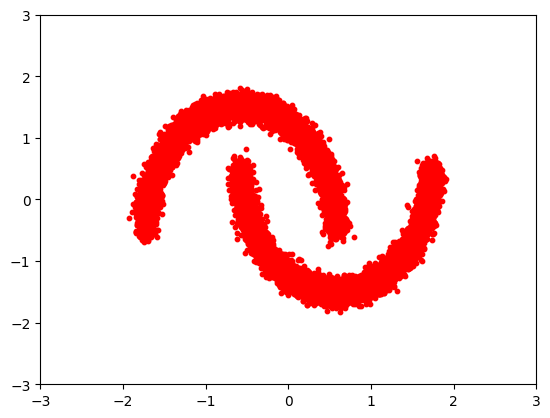

In [70]:
n_samples = 20000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
xlim, ylim = [-3, 3], [-3, 3]
plt.scatter(X[:, 0], X[:, 1], s=10, color="red")
plt.xlim(xlim)
plt.ylim(ylim)

Now we can program our custom bijector.

In [71]:
class RNVP(
    bijectors.AbstractFwdLogDetJacBijector, bijectors.AbstractInvLogDetJacBijector
):
    _is_constant_jacobian: bool
    _is_constant_log_det: bool
    sig_net: eqx.Module
    mu_net: eqx.Module
    d: int
    k: int
    flip: bool

    def __init__(self, d, k, flip, key, hidden=32):
        self._is_constant_jacobian = False
        self._is_constant_log_det = False
        self.flip = flip
        keys = jax.random.split(key, 4)

        self.d = d
        self.k = k

        self.sig_net = eqx.nn.Sequential(
            [
                eqx.nn.Linear(k, hidden, key=keys[0]),
                eqx.nn.Lambda(jax.nn.swish),
                eqx.nn.Linear(hidden, d - k, key=keys[1]),
            ]
        )

        self.mu_net = eqx.nn.Sequential(
            [
                eqx.nn.Linear(k, hidden, key=keys[2]),
                eqx.nn.Lambda(jax.nn.swish),
                eqx.nn.Linear(hidden, d - k, key=keys[3]),
            ]
        )

    def forward_and_log_det(self, x):
        x1, x2 = x[: self.k], x[self.k :]

        if self.flip:
            x1, x2 = x2, x1

        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * jnp.exp(sig) + self.mu_net(x1)

        if self.flip:
            z1, z2 = z2, z1

        z_hat = jnp.concatenate([z1, z2])
        log_det = jnp.sum(sig)

        return z_hat, log_det

    def inverse(self, y):
        z1, z2 = y[: self.k], y[self.k :]

        if self.flip:
            z1, z2 = z2, z1

        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * jnp.exp(-self.sig_net(z1))

        if self.flip:
            x1, x2 = x2, x1

        x_hat = jnp.concatenate([x1, x2])
        return x_hat

    def forward(self, x):
        y, _ = self.forward_and_log_det(x)
        return y

    def inverse_and_log_det(self, y):
        raise NotImplementedError(
            f"Bijector {self.name} does not implement `inverse_and_log_det`."
        )

    def same_as(self, other) -> bool:
        return type(other) is RNVP

Since we want to stack these together, we can use a chain bijector to accomplish this.

In [72]:
n = 3
key = jax.random.key(0)
keys = jax.random.split(key, n)
bijector_chain = bijectors.Chain([RNVP(2, 1, i % 2, keys[i], 600) for i in range(n)])

Flows map p(x) -> p(z) via a function F (samples are generated via F^-1(z)). In general, p(z) is chosen to have some tractable form for sampling and calculating log probabilities. A common choice is Gaussian, which we go with here.

In [73]:
base_distribution = distributions.MultivariateNormalDiag(jnp.zeros(2))
base_distribution_sample = eqx.filter_vmap(base_distribution.sample)
base_distribution_log_prob = eqx.filter_vmap(base_distribution.log_prob)

Here we plot the initial, untrained, samples.

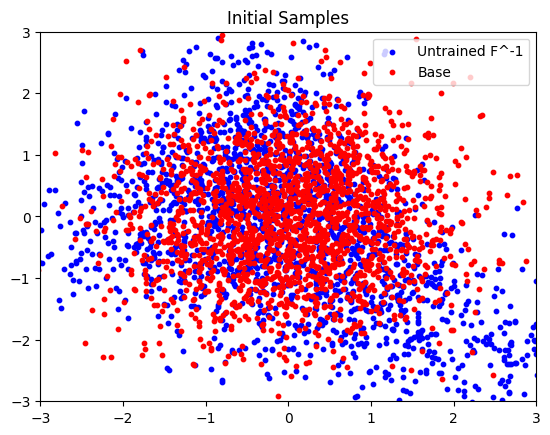

In [74]:
num_samples = 2000
base_samples = base_distribution_sample(jax.random.split(key, num_samples))
transformed_samples = eqx.filter_vmap(bijector_chain.inverse)(base_samples)

plt.scatter(
    transformed_samples[:, 0],
    transformed_samples[:, 1],
    s=10,
    color="blue",
    label="Untrained F^-1",
)
plt.scatter(base_samples[:, 0], base_samples[:, 1], s=10, color="red", label="Base")
plt.legend()
plt.xlim(xlim)
plt.ylim(ylim)
plt.title("Initial Samples")
plt.show()

In [75]:
learning_rate = 1e-3
num_iters = 1000
batch_size = 128

optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(bijector_chain, eqx.is_inexact_array))


def log_prob(params: bijectors.AbstractBijector, data):
    f_inv, log_det = params.forward_and_log_det(data)
    log_prob = base_distribution.log_prob(f_inv) + log_det
    return log_prob


def loss(params, batch):
    return -jnp.mean(eqx.filter_vmap(log_prob, in_axes=(None, 0))(params, batch))


@eqx.filter_jit
def update(model, batch, opt_state, optimizer):
    val, grads = eqx.filter_value_and_grad(loss)(model, batch)
    update, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, update)
    return model, opt_state, val


losses = []

for i in range(num_iters):
    if i % 500 == 0:
        print(i)
    batch_indices = jax.random.choice(
        key, jnp.arange(X.shape[0]), (batch_size,), replace=False
    )
    batch = X[batch_indices]
    bijector_chain, opt_state, loss_val = update(
        bijector_chain, batch, opt_state, optimizer
    )
    losses.append(loss_val)

0
500


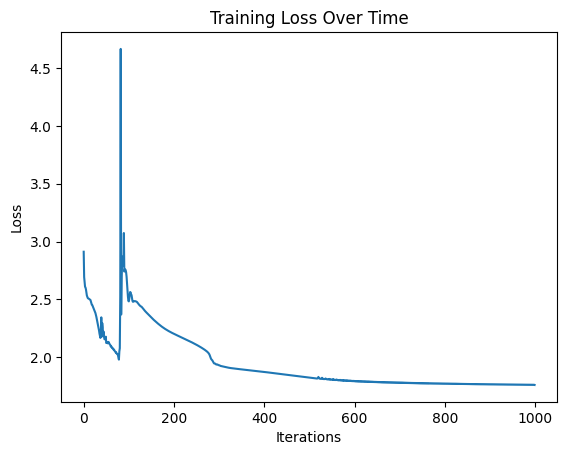

In [76]:
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

After training we can plot both F(x) (to see where the true data ends up in our sampled space) and F^-1(z) to generate new samples.

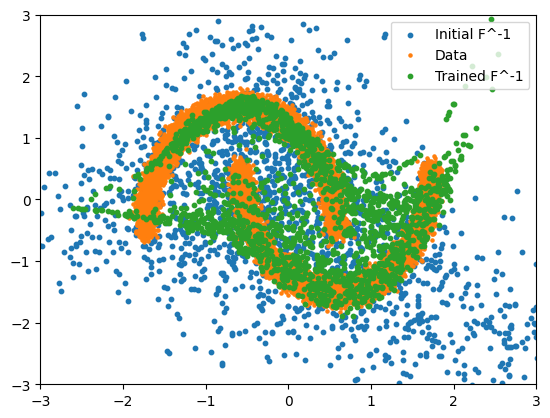

In [77]:
trained_params = bijector_chain

transformed_samples_trained = eqx.filter_vmap(bijector_chain.inverse)(base_samples)

plt.scatter(
    transformed_samples[:, 0], transformed_samples[:, 1], s=10, label="Initial F^-1"
)
plt.scatter(X[:, 0], X[:, 1], s=5, label="Data")
plt.scatter(
    transformed_samples_trained[:, 0],
    transformed_samples_trained[:, 1],
    s=10,
    label="Trained F^-1",
)
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.show()

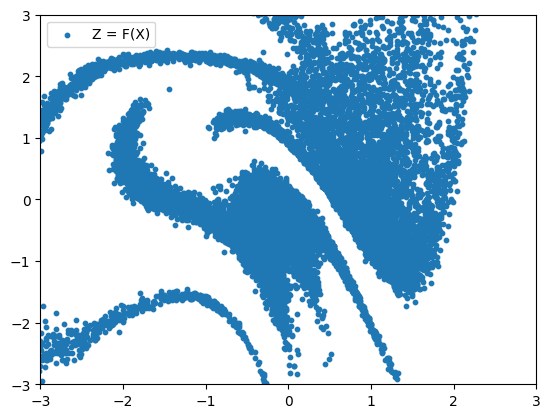

In [78]:
data_to_noise = eqx.filter_vmap(bijector_chain.forward)(X)

plt.scatter(data_to_noise[:, 0], data_to_noise[:, 1], s=10, label="Z = F(X)")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.show()